# 천체 유형 분류 경진
## Public 2위

## 1. 라이브러리 및 데이터(Library & Data)

In [22]:
# basic
import os
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import re

# plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 경고메세지 
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# fold
from sklearn.model_selection import KFold,StratifiedKFold

# 모델
from xgboost import XGBClassifier

# 평가방법

from sklearn.metrics import log_loss

In [23]:
#EDA 데이터
eda = pd.read_csv('../data/train.csv')

#훈련 및 예측데이터
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv', index_col=0)
df_train.head()

,id,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,...,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
0,0,QSO,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,...,22.504317,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340
1,1,QSO,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,...,21.360701,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314
2,2,QSO,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,...,17.867253,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928
3,3,QSO,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,...,20.433907,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855
4,4,STAR_RED_DWARF,612,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,...,25.859229,22.426929,21.673551,19.610012,18.376141,24.877052,23.147993,21.475342,19.487330,18.375655


In [24]:
# 훈련데이터 요약
df_train.describe()

,id,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,...,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199991.00000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,...,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,99995.00000,360.830152,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,...,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,57732.57318,225.305890,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,...,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,0.00000,1.000000,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,...,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,49997.50000,174.000000,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,...,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,99995.00000,349.000000,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,...,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,149992.50000,526.000000,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,...,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,199990.00000,1000.000000,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,...,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


In [25]:
# 테스트데이터 요약
df_test.describe()

,id,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,...,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,...,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000
mean,204995.000000,359.327805,20.987400,19.878440,19.280218,18.873165,18.618385,21.184506,20.091376,19.497732,...,20.715429,19.462021,18.995001,18.616519,18.411996,20.739001,19.534844,18.935095,18.522308,18.281069
std,2889.493756,223.928862,2.111703,2.573890,1.709344,1.720713,1.702236,1.990940,1.865064,1.710070,...,2.807434,13.971203,1.979225,1.970463,2.373022,2.187025,1.957506,1.856617,1.796820,1.867582
min,199991.000000,1.000000,-7.248195,-42.663871,9.134712,-22.522266,13.349827,9.390439,8.188752,12.288183,...,-98.181975,-1348.068776,-23.908952,-8.356654,-64.917293,12.419765,13.617577,13.382832,12.955113,12.395695
25%,202493.000000,174.000000,19.655525,18.671025,18.037847,17.742016,17.424701,19.940430,18.892043,18.253627,...,19.249432,18.104265,17.475078,17.043615,16.805557,19.268471,18.064625,17.424393,16.971911,16.715685
50%,204995.000000,346.000000,20.854404,19.910333,19.444925,19.033283,18.594713,21.040735,20.071658,19.627904,...,20.371014,19.582955,19.197068,18.684269,18.171966,20.412702,19.541261,19.155839,18.635195,18.095883
75%,207497.000000,525.000000,22.160801,21.150040,20.489912,20.083814,19.878652,22.339213,21.402558,20.756306,...,21.803705,21.025719,20.428279,20.015701,19.815916,21.992969,20.981396,20.389215,19.970657,19.823902
max,209999.000000,1000.000000,37.681143,182.654452,31.883768,47.227391,34.946057,41.169991,47.160580,29.266687,...,65.392087,106.962571,41.850633,52.221528,74.747394,32.641240,28.814977,27.579664,26.471555,24.461973


In [26]:
# type별 비율
# Class는 총 19 개로 QSO는 약25% 차지하고 STAR_PN는 0.000065%가 있어 매우 불균형이 심함
eda['type'].value_counts()/len(eda)

QSO                    0.248411
GALAXY                 0.186743
SERENDIPITY_BLUE       0.108805
SPECTROPHOTO_STD       0.073153
REDDEN_STD             0.073093
STAR_RED_DWARF         0.068753
STAR_BHB               0.067503
SERENDIPITY_FIRST      0.035662
ROSAT_D                0.032901
STAR_CATY_VAR          0.032531
SERENDIPITY_DISTANT    0.023271
STAR_CARBON            0.016286
SERENDIPITY_RED        0.012811
STAR_WHITE_DWARF       0.010800
STAR_SUB_DWARF         0.005770
STAR_BROWN_DWARF       0.002500
SKY                    0.000635
SERENDIPITY_MANUAL     0.000305
STAR_PN                0.000065
Name: type, dtype: float64

## 2. 데이터 전처리(Data Cleansing & Pre-Processing)

In [27]:
# 데이터 type를 변경함으로서 memory 줄임
for col in df_train.columns:
    if df_train[col].dtype=='float64': df_train[col] = df_train[col].astype('float32')
    if df_train[col].dtype=='int64': df_train[col] = df_train[col].astype('int32')
        
for col in df_test.columns:
    if df_test[col].dtype=='float64': df_test[col] = df_test[col].astype('float32')
    if df_test[col].dtype=='int64': df_test[col] = df_test[col].astype('int32')
        
# type 및 data columns 리스트 생성
a = eda['type'].unique()
b = ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z']

# 컬럼별 매우 높거나 낮은값 제거
# EDA를 위해 비정상적으로 높은값을 제외 했지만 실제 모델에서는 제거하지 않았습니다.
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.001)
    q3 = df_in[col_name].quantile(0.99)
    iqr = q3-q1 
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_high)]
    return df_out
for i, name in enumerate(b):
    eda = remove_outlier(eda, name)

## 3. 탐색적 자료분석(Exploratory Data Analysis)

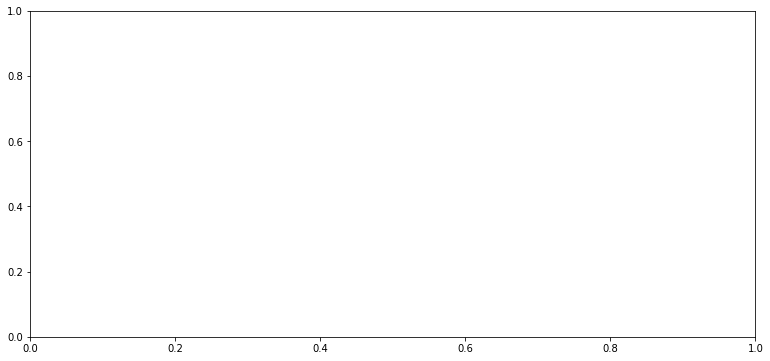

In [28]:
# EDA idea
# 아래 kdeplot 처럼 tree모델은 수직으로 모델을 분류 합니다. 
plt.figure(figsize=(13,6))
for i, name in enumerate(a):
    sns.kdeplot(eda[eda['type'] == name]['psfMag_u'], label=name,legend=True)

In [29]:
# 예를들어 tree모델은 psfMag_u< 18.5일 경우 높은확률로 SPECTROPHOTO_STD를 분류합니다.
eda[eda['psfMag_u']<18.5]['type'].value_counts()

Series([], Name: type, dtype: int64)

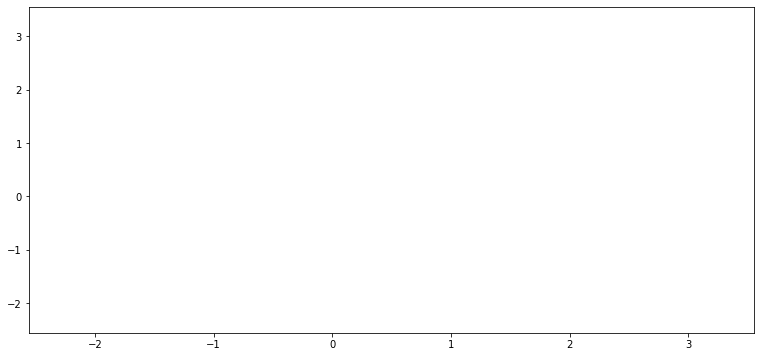

In [30]:
# minus 상호작용
# 아래 scatterplot를 보면 minus 상호작용을 할때 대각선 방향으로 군집되어있는 것을 볼 수 있습니다. 
plt.figure(figsize=(13,6))
for i, name in enumerate(a):
    sns.scatterplot(eda[eda['type'] == name]['psfMag_r'],eda[eda['type'] == name]['fiberMag_z'], label=name)

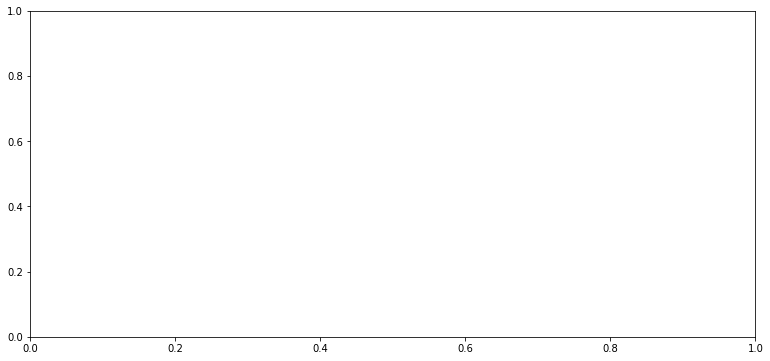

In [31]:
# 아래 kdeplot를 그리면 'psfMag_u - fiberMag_z' > 4 일 때 주황색 또는 보라색으로 분류합니다.
# 결론적으로 minus 상호작용으로 인해 tree가 수직으로 분류할 수 있는 다양한 feature를 생성할 수 있습니다.
eda['psfMag_u - fiberMag_z'] = eda['psfMag_r'] - eda['fiberMag_z'] 
plt.figure(figsize=(13,6))
for i, name in enumerate(a):
    sns.kdeplot(eda[eda['type'] == name]['psfMag_u - fiberMag_z'], label=name,legend=True)

In [ ]:
#  division 상호작용
# +상호작요과 %상호작용을 시도 했지만 소용이 없었습니다.
# 모든 변수의 / 시도했고 type과의 상관관계가 0.15보다 크거나 -0.1보다 작은 변수를 생성했습니다.

eda['modelMag_z / modelMag_g'] = eda['modelMag_z']/eda['modelMag_g']
plt.figure(figsize=(13,6))
for i, name in enumerate(a):
    sns.kdeplot(eda[eda['type'] == name]['modelMag_z / modelMag_g'], label=name,legend=True)

In [ ]:
# diff
# 한 row의 대해 max - min값이 모델 성능을 높여주었습니다.
# psgMag, fiberMag 별 max- min도 시도 했지만 성능이 좋아지지 않았습니다.
eda['max-min'] = eda[b].max(axis=1)-eda[b].min(axis=1)
plt.figure(figsize=(13,6))
for i, name in enumerate(a):
    sns.kdeplot(eda[eda['type'] == name]['max-min'], label=name,legend=True)

In [ ]:
# fiberID는 매우 중요한 변수입니다. fiberID 800이상은 QSO 타입만 있습니다. 가설이지만 fiberID 800이상은 QSO만 예측할 수 있을까요?
plt.figure(figsize=(13,6))
for i, name in enumerate(a):
    sns.kdeplot(eda[eda['type'] == name]['fiberID'], label=name,legend=True)

In [ ]:
# fiber % 10을 할 떄 QSO의 경우 홀수와 짝수에 따라 비율이 다른 것을 볼 수 있었습니다
plt.figure(figsize=(13,6))
for i, name in enumerate(a):
    sns.kdeplot(eda[eda['type'] == name]['fiberID']%10, label=name,legend=True)

In [ ]:
# QSO의 경우   fiberID % 10 에 대해 짝수의 비율이 홀수에 비해 약 2.5배이상 많습니다.
eda['fiberID2'] = eda['fiberID']%10
eda[eda['type']=='QSO']['fiberID2'].value_counts()

In [ ]:
# fiberID % 100 변수 또한 type별 다른 분포를 나타 냅니다.
plt.figure(figsize=(13,6))
for i, name in enumerate(a):
    sns.kdeplot(eda[eda['type'] == name]['fiberID']%100, label=name,legend=True)

## 4. 변수 선택 및 모델 구축(Feature Engineering & Initial Modeling)

In [35]:

# labeling
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

df_train['type_num'] = df_train['type'].apply(lambda x: to_number(x, column_number))
# type 및 data columns 리스트 생성
a = eda['type'].unique()
b = ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z']

In [36]:
# minus 상호작용
for i , name in enumerate(b):
    for i2 , name2 in enumerate(b):
        if name==name2 :
            pass
        else :
            df_train[str(name)+"-"+str(name2)] = df_train[name]-df_train[name2]
            df_test[str(name)+"-"+str(name2)] = df_test[name]-df_test[name2]
print('df_train : ',df_train.shape)
print('df_test : ', df_test.shape)

df_train :  (199991, 404)
df_test :  (10009, 402)


In [37]:
# division 상호작용
# corr 기준으로  0.15이상 -0.1이하의 변수를 선택했습니다.
df_train['modelMag_z/modelMag_g']=	df_train['modelMag_z']/df_train['modelMag_g']
df_train['modelMag_z/fiberMag_g']=	df_train['modelMag_z']/df_train['fiberMag_g']
df_train['modelMag_z/psfMag_z']=	df_train['modelMag_z']/df_train['psfMag_z']
df_train['modelMag_z/psfMag_u']=	df_train['modelMag_z']/df_train['psfMag_u']
df_train['modelMag_z/psfMag_g']=	df_train['modelMag_z']/df_train['psfMag_g']
df_train['modelMag_i/modelMag_g']=	df_train['modelMag_i']/df_train['modelMag_g']
df_train['modelMag_i/fiberMag_g']=	df_train['modelMag_i']/df_train['fiberMag_g']
df_train['modelMag_i/psfMag_i']=	df_train['modelMag_i']/df_train['psfMag_i']
df_train['modelMag_r/modelMag_u']=	df_train['modelMag_r']/df_train['modelMag_u']
df_train['modelMag_r/modelMag_g']=	df_train['modelMag_r']/df_train['modelMag_g']
df_train['modelMag_i/psfMag_u']=	df_train['modelMag_i']/df_train['psfMag_u']
df_train['modelMag_i/psfMag_g'] =	df_train['modelMag_i']/df_train['psfMag_g']
df_train['modelMag_r/fiberMag_u']=	df_train['modelMag_r']/df_train['fiberMag_u']
df_train['modelMag_r/fiberMag_g']=	df_train['modelMag_r']/df_train['fiberMag_g']
df_train['modelMag_r/fiberMag_r']=	df_train['modelMag_r']/df_train['fiberMag_r']
df_train['modelMag_r/psfMag_u']=	df_train['modelMag_r']/df_train['psfMag_u']
df_train['modelMag_r/psfMag_g']=	df_train['modelMag_r']/df_train['psfMag_g']
df_train['modelMag_r/psfMag_r']=	df_train['modelMag_r']/df_train['psfMag_r']
df_train['modelMag_u/modelMag_z']=	df_train['modelMag_u']/df_train['modelMag_z']
df_train['modelMag_g/psfMag_u']=	df_train['modelMag_g']/df_train['psfMag_u']
df_train['modelMag_g/psfMag_g']=	df_train['modelMag_g']/df_train['psfMag_g']
df_train['modelMag_u/modelMag_g']=	df_train['modelMag_u']/df_train['modelMag_g']
df_train['modelMag_r/psfMag_u']=	df_train['modelMag_r']/df_train['psfMag_u']
df_train['petroMag_i/fiberMag_g']=	df_train['petroMag_i']/df_train['fiberMag_g']
df_train['petroMag_i/psfMag_u']=	df_train['petroMag_i']/df_train['psfMag_u']
df_train['petroMag_i/psfMag_g']=	df_train['petroMag_i']/df_train['psfMag_g']
df_train['fiberMag_z/fiberMag_g']=	df_train['fiberMag_z']/df_train['fiberMag_g']
df_train['fiberMag_z/psfMag_g']=	df_train['fiberMag_z']/df_train['psfMag_g']
df_train['fiberMag_z/psfMag_u']=	df_train['fiberMag_z']/df_train['psfMag_u']
df_train['fiberMag_r/modelMag_i']=	df_train['fiberMag_r']/df_train['modelMag_i']
df_train['fiberMag_r/modelMag_z']=	df_train['fiberMag_r']/df_train['modelMag_z']
df_train['fiberMag_r/psfMag_u']=	df_train['fiberMag_r']/df_train['psfMag_u']
df_train['fiberMag_r/psfMag_g']=	df_train['fiberMag_r']/df_train['psfMag_g']
df_train['psfMag_z/psfMag_u']=	    df_train['psfMag_z']/df_train['psfMag_u']
df_train['psfMag_z/psfMag_g']=	df_train['psfMag_z']/df_train['psfMag_g']
df_train['psfMag_i/psfMag_u']=	df_train['psfMag_i']/df_train['psfMag_u']
df_train['psfMag_g/modelMag_z']=	df_train['psfMag_g']/df_train['modelMag_z']

df_test['modelMag_z/modelMag_g']=	df_test['modelMag_z']/df_test['modelMag_g']
df_test['modelMag_z/fiberMag_g']=	df_test['modelMag_z']/df_test['fiberMag_g']
df_test['modelMag_z/psfMag_z']=	df_test['modelMag_z']/df_test['psfMag_z']
df_test['modelMag_z/psfMag_u']=	df_test['modelMag_z']/df_test['psfMag_u']
df_test['modelMag_z/psfMag_g']=	df_test['modelMag_z']/df_test['psfMag_g']
df_test['modelMag_i/modelMag_g']=	df_test['modelMag_i']/df_test['modelMag_g']
df_test['modelMag_i/fiberMag_g']=	df_test['modelMag_i']/df_test['fiberMag_g']
df_test['modelMag_i/psfMag_i']=	df_test['modelMag_i']/df_test['psfMag_i']
df_test['modelMag_r/modelMag_u']=	df_test['modelMag_r']/df_test['modelMag_u']
df_test['modelMag_r/modelMag_g']=	df_test['modelMag_r']/df_test['modelMag_g']
df_test['modelMag_i/psfMag_u']=	df_test['modelMag_i']/df_test['psfMag_u']
df_test['modelMag_i/psfMag_g'] =	df_test['modelMag_i']/df_test['psfMag_g']
df_test['modelMag_r/fiberMag_u']=	df_test['modelMag_r']/df_test['fiberMag_u']
df_test['modelMag_r/fiberMag_g']=	df_test['modelMag_r']/df_test['fiberMag_g']
df_test['modelMag_r/fiberMag_r']=	df_test['modelMag_r']/df_test['fiberMag_r']
df_test['modelMag_r/psfMag_u']=	df_test['modelMag_r']/df_test['psfMag_u']
df_test['modelMag_r/psfMag_g']=	df_test['modelMag_r']/df_test['psfMag_g']
df_test['modelMag_r/psfMag_r']=	df_test['modelMag_r']/df_test['psfMag_r']
df_test['modelMag_u/modelMag_z']=	df_test['modelMag_u']/df_test['modelMag_z']
df_test['modelMag_g/psfMag_u']=	df_test['modelMag_g']/df_test['psfMag_u']
df_test['modelMag_g/psfMag_g']=	df_test['modelMag_g']/df_test['psfMag_g']
df_test['modelMag_u/modelMag_g']=	df_test['modelMag_u']/df_test['modelMag_g']
df_test['modelMag_r/psfMag_u']=	df_test['modelMag_r']/df_test['psfMag_u']
df_test['petroMag_i/fiberMag_g']=	df_test['petroMag_i']/df_test['fiberMag_g']
df_test['petroMag_i/psfMag_u']=	df_test['petroMag_i']/df_test['psfMag_u']
df_test['petroMag_i/psfMag_g']=	df_test['petroMag_i']/df_test['psfMag_g']
df_test['fiberMag_z/fiberMag_g']=	df_test['fiberMag_z']/df_test['fiberMag_g']
df_test['fiberMag_z/psfMag_g']=	df_test['fiberMag_z']/df_test['psfMag_g']
df_test['fiberMag_z/psfMag_u']=	df_test['fiberMag_z']/df_test['psfMag_u']
df_test['fiberMag_r/modelMag_i']=	df_test['fiberMag_r']/df_test['modelMag_i']
df_test['fiberMag_r/modelMag_z']=	df_test['fiberMag_r']/df_test['modelMag_z']
df_test['fiberMag_r/psfMag_u']=	df_test['fiberMag_r']/df_test['psfMag_u']
df_test['fiberMag_r/psfMag_g']=	df_test['fiberMag_r']/df_test['psfMag_g']
df_test['psfMag_z/psfMag_u']=	    df_test['psfMag_z']/df_test['psfMag_u']
df_test['psfMag_z/psfMag_g']=	df_test['psfMag_z']/df_test['psfMag_g']
df_test['psfMag_i/psfMag_u']=	df_test['psfMag_i']/df_test['psfMag_u']
df_test['psfMag_g/modelMag_z']=	df_test['psfMag_g']/df_test['modelMag_z']
# diff
df_train['max-min'] = df_train[b].max(axis=1)-df_train[b].min(axis=1)
df_test['max-min'] = df_test[b].max(axis=1)-df_train[b].min(axis=1)
# fiberID
df_train['fiberID2'] = df_train['fiberID']%2
df_test['fiberID2'] = df_test['fiberID']%2
df_train['fiberID3'] = df_train['fiberID']%10
df_test['fiberID3'] = df_test['fiberID']%10
df_train['fiberID4'] = df_train['fiberID']%100
df_test['fiberID4'] = df_test['fiberID']%100


In [38]:
#feature importance 기준으로 제거했습니다.
cols = [c for c in df_train.columns if c not in ['id','type', 'type_num',
 'petroMag_z-petroMag_g', 'petroMag_z-modelMag_g', 'petroMag_g-modelMag_z', 'petroMag_u-fiberMag_i', 'modelMag_r-petroMag_u', 'petroMag_z-petroMag_u', 'petroMag_z-fiberMag_g', 'fiberMag_z-petroMag_u',
 'modelMag_i-fiberMag_u', 'petroMag_u-modelMag_r', 'petroMag_u-psfMag_i', 'modelMag_i-petroMag_u', 'fiberMag_z-fiberMag_u', 'petroMag_r-petroMag_u', 'psfMag_z-psfMag_u', 'fiberMag_g-petroMag_z',
 'petroMag_i-fiberMag_u', 'modelMag_g-petroMag_z', 'fiberMag_z-psfMag_u', 'psfMag_z-petroMag_g', 'psfMag_g-petroMag_z', 'fiberMag_i-petroMag_g', 'modelMag_i-petroMag_g', 'petroMag_u-modelMag_i',
 'petroMag_g-petroMag_z', 'fiberMag_u-petroMag_i', 'modelMag_u-fiberMag_z', 'fiberMag_z-modelMag_u', 'modelMag_u-petroMag_z', 'psfMag_u-modelMag_i', 'petroMag_u-petroMag_z', 'psfMag_i-petroMag_u',
 'modelMag_i-psfMag_u', 'fiberMag_z-petroMag_g', 'modelMag_z-petroMag_g', 'petroMag_u-petroMag_i', 'petroMag_g-fiberMag_z', 'modelMag_u-petroMag_i', 'petroMag_r-psfMag_z', 'petroMag_u-psfMag_z',
'petroMag_z-psfMag_r', 'fiberMag_u-petroMag_z', 'petroMag_u-fiberMag_r', 'psfMag_i-fiberMag_u', 'psfMag_z-psfMag_r', 'psfMag_i-psfMag_u', 'petroMag_i-psfMag_u', 'petroMag_z-fiberMag_u',
 'petroMag_z-petroMag_r', 'petroMag_g-fiberMag_i', 'petroMag_u-psfMag_r', 'petroMag_u-modelMag_z', 'fiberMag_i-fiberMag_u', 'petroMag_i-petroMag_g', 'petroMag_i-modelMag_u', 'modelMag_z-psfMag_g',
 'modelMag_g-fiberMag_z', 'modelMag_u-modelMag_i', 'fiberMag_z-fiberMag_r', 'psfMag_u-psfMag_z', 'petroMag_i-petroMag_u', 'fiberMag_z-psfMag_g', 'modelMag_z-modelMag_u', 'fiberMag_u-psfMag_i',
 'modelMag_u-psfMag_i', 'modelMag_g-modelMag_z', 'modelMag_g-psfMag_z', 'modelMag_z-modelMag_g', 'petroMag_z-psfMag_g', 'psfMag_u-psfMag_i', 'psfMag_u-fiberMag_z', 'petroMag_g-petroMag_i',
 'psfMag_r-petroMag_u', 'modelMag_r-modelMag_u', 'fiberMag_u-modelMag_z', 'psfMag_u-modelMag_z', 'psfMag_i-psfMag_g', 'fiberMag_u-modelMag_i', 'modelMag_i-modelMag_u',
 'petroMag_r-modelMag_u', 'modelMag_u-petroMag_r', 'modelMag_r-petroMag_i', 'petroMag_r-fiberMag_u', 'modelMag_r-petroMag_g', 'modelMag_z-petroMag_u', 'modelMag_u-fiberMag_i', 'psfMag_r-fiberMag_u',
 'psfMag_r-petroMag_z', 'psfMag_z-modelMag_u', 'psfMag_z-psfMag_g', 'fiberMag_z-psfMag_r', 'psfMag_i-modelMag_u', 'modelMag_z-fiberMag_g', 'fiberMag_i-psfMag_u', 'fiberMag_z-modelMag_g',
 'fiberMag_u-modelMag_r', 'fiberMag_u-fiberMag_z', 'petroMag_g-modelMag_r', 'petroMag_i-fiberMag_g', 'fiberMag_z-modelMag_r', 'petroMag_r-modelMag_z', 'petroMag_r-petroMag_z', 'psfMag_z-fiberMag_u',
 'modelMag_z-fiberMag_u', 'psfMag_g-psfMag_z', 'psfMag_u-petroMag_z', 'fiberMag_u-fiberMag_i', 'petroMag_u-fiberMag_z', 'fiberMag_r-petroMag_u', 'fiberMag_g-psfMag_z', 'petroMag_z-modelMag_r',
 'modelMag_g-petroMag_i', 'fiberMag_g-psfMag_i', 'petroMag_i-psfMag_r', 'petroMag_r-psfMag_u', 'modelMag_u-modelMag_r', 'petroMag_u-petroMag_r', 'fiberMag_r-psfMag_u', 'petroMag_r-fiberMag_z',
 'fiberMag_i-petroMag_u', 'psfMag_z-petroMag_u', 'petroMag_z-modelMag_u', 'petroMag_g-modelMag_i', 'petroMag_z-psfMag_i', 'modelMag_u-psfMag_z', 'psfMag_i-petroMag_g', 'psfMag_u-petroMag_r',
 'modelMag_z-petroMag_r', 'fiberMag_r-fiberMag_u', 'petroMag_i-fiberMag_z', 'modelMag_z-modelMag_r', 'petroMag_i-modelMag_g', 'modelMag_r-fiberMag_z', 'modelMag_i-fiberMag_g', 'psfMag_g-psfMag_i',
 'petroMag_z-psfMag_u', 'psfMag_g-modelMag_z', 'psfMag_u-modelMag_r', 'fiberMag_u-psfMag_z', 'fiberMag_i-modelMag_u', 'petroMag_g-psfMag_z', 'modelMag_r-fiberMag_i', 'fiberMag_i-psfMag_g',
 'fiberMag_u-fiberMag_r', 'petroMag_g-psfMag_i', 'fiberMag_z-fiberMag_g', 'modelMag_r-petroMag_z', 'modelMag_u-fiberMag_r', 'modelMag_g-fiberMag_i', 'psfMag_z-fiberMag_g', 'fiberMag_r-petroMag_z',
 'modelMag_z-fiberMag_r', 'modelMag_r-fiberMag_u', 'modelMag_z-psfMag_u', 'fiberMag_g-modelMag_z', 'petroMag_z-fiberMag_i', 'petroMag_u-fiberMag_g', 'modelMag_z-psfMag_r', 'psfMag_r-psfMag_z',
 'petroMag_i-psfMag_g', 'psfMag_i-petroMag_z', 'petroMag_g-fiberMag_r', 'petroMag_g-fiberMag_u', 'modelMag_i-modelMag_g', 'modelMag_i-petroMag_z', 'petroMag_r-petroMag_i', 'psfMag_u-petroMag_i',
 'psfMag_g-fiberMag_z', 'petroMag_z-modelMag_i', 'psfMag_u-fiberMag_r', 'modelMag_u-psfMag_r', 'psfMag_u-psfMag_r', 'psfMag_g-modelMag_i', 'petroMag_r-psfMag_g', 'petroMag_g-petroMag_u',
 'petroMag_i-fiberMag_r', 'modelMag_z-petroMag_i', 'petroMag_i-petroMag_r', 'modelMag_g-petroMag_u', 'petroMag_g-petroMag_r', 'psfMag_z-modelMag_g', 'fiberMag_u-petroMag_r', 'petroMag_r-fiberMag_i',
 'psfMag_g-fiberMag_i', 'fiberMag_g-petroMag_i', 'petroMag_r-petroMag_g', 'fiberMag_i-fiberMag_g', 'modelMag_u-modelMag_z', 'psfMag_i-fiberMag_g', 'psfMag_g-petroMag_i', 'petroMag_z-petroMag_i',
 'modelMag_g-fiberMag_u', 'psfMag_z-petroMag_i', 'petroMag_z-fiberMag_r', 'petroMag_u-petroMag_g', 'psfMag_z-modelMag_i', 'modelMag_g-psfMag_i', 'fiberMag_g-fiberMag_z', 'psfMag_u-fiberMag_i',
 'fiberMag_u-psfMag_r', 'petroMag_r-fiberMag_g', 'modelMag_r-psfMag_u', 'psfMag_i-modelMag_g', 'psfMag_r-modelMag_u', 'modelMag_z-fiberMag_z', 'modelMag_i-psfMag_g', 'fiberMag_u-petroMag_g',
 'fiberMag_g-modelMag_i', 'psfMag_r-petroMag_i', 'fiberMag_r-psfMag_g', 'psfMag_z-petroMag_r', 'petroMag_u-modelMag_g', 'fiberMag_g-fiberMag_i', 'psfMag_z-fiberMag_r', 'modelMag_r-fiberMag_g',
 'modelMag_r-psfMag_z', 'petroMag_i-modelMag_z', 'psfMag_i-petroMag_r', 'petroMag_i-psfMag_z', 'psfMag_g-petroMag_u', 'petroMag_r-psfMag_i', 'modelMag_u-petroMag_g', 'modelMag_z-fiberMag_i',
 'psfMag_u-modelMag_g', 'fiberMag_z-petroMag_r', 'psfMag_g-psfMag_u', 'fiberMag_i-fiberMag_r', 'psfMag_r-psfMag_u', 'psfMag_z-modelMag_r', 'modelMag_i-fiberMag_z', 'petroMag_i-modelMag_r',
 'fiberMag_i-petroMag_r', 'petroMag_i-petroMag_z', 'fiberMag_i-modelMag_g', 'fiberMag_r-psfMag_i', 'modelMag_i-psfMag_z', 'fiberMag_r-modelMag_u', 'petroMag_g-modelMag_u', 'petroMag_u-psfMag_g',
 'fiberMag_g-modelMag_r', 'fiberMag_z-modelMag_i', 'psfMag_r-modelMag_z', 'psfMag_g-petroMag_r', 'fiberMag_i-petroMag_z', 'modelMag_g-petroMag_r', 'fiberMag_g-modelMag_u', 'fiberMag_r-psfMag_z',
 'psfMag_i-modelMag_r', 'psfMag_i-psfMag_z', 'fiberMag_i-psfMag_r', 'modelMag_i-fiberMag_r', 'fiberMag_g-petroMag_r', 'psfMag_r-fiberMag_z', 'psfMag_u-petroMag_g', 'modelMag_r-psfMag_i',
 'fiberMag_g-fiberMag_u', 'fiberMag_r-modelMag_i', 'fiberMag_r-petroMag_g', 'fiberMag_r-fiberMag_z', 'psfMag_u-petroMag_u', 'petroMag_u-fiberMag_u', 'modelMag_z-modelMag_i', 'psfMag_r-psfMag_g',
 'petroMag_g-psfMag_u', 'modelMag_u-fiberMag_g', 'modelMag_u-petroMag_u', 'petroMag_r-modelMag_i', 'fiberMag_u-modelMag_g', 'fiberMag_r-petroMag_i', 'psfMag_z-psfMag_i', 'petroMag_u-modelMag_u',
 'modelMag_u-psfMag_g', 'modelMag_r-modelMag_z', 'fiberMag_i-modelMag_r', 'psfMag_i-fiberMag_z', 'psfMag_r-petroMag_g', 'fiberMag_g-psfMag_u', 'petroMag_g-psfMag_r', 'fiberMag_g-petroMag_u',
 'modelMag_g-psfMag_u', 'petroMag_r-psfMag_r', 'psfMag_g-fiberMag_u', 'petroMag_r-fiberMag_r', 'fiberMag_u-fiberMag_g', 'psfMag_u-psfMag_g', 'fiberMag_z-fiberMag_i', 'psfMag_g-modelMag_r',
 'petroMag_r-modelMag_g', 'fiberMag_i-psfMag_z', 'psfMag_r-fiberMag_g', 'modelMag_r-psfMag_r', 'fiberMag_r-modelMag_z', 'petroMag_g-modelMag_g', 'psfMag_r-fiberMag_i', 'modelMag_u-modelMag_g',
 'fiberMag_z-modelMag_z', 'modelMag_r-psfMag_g', 'petroMag_z-psfMag_z', 'fiberMag_r-fiberMag_g', 'modelMag_g-modelMag_u', 'fiberMag_z-petroMag_i']]


In [39]:
#모델학습 변수 갯수(140개)
print('df_train : ',df_train[cols].shape)
print('df_test : ', df_test[cols].shape)

df_train :  (199991, 140)
df_test :  (10009, 140)


## 5. 모델 학습 및 검증(Model Tuning & Evaluation)

Modeling  
총 140개의 변수를 사용했습니다.(minus, division, diffm fiberID)  
데이터와 class가 많고 데이터 자체의 불균형이 심해 모델 튜닝이 매우 힘들었습니다.  
저의 logloss를 낮춘 방법은 OOF와 prams입니다.  

최종모델(XGBoost)
- fold1 : 0.3311
- fold2 : 0.3235
- fold3 : 0.3230
- fold4 : 0.3206
- fold5 : 0.3203

cv : 0.3237
public lb : 0.3256
private lb : 0.3261
oof
저의 교차검증은 oof를 사용했으며 안정정인 CV를 보여줬으며 앙상블의 효과를 통해 Logloss를 낮출 수 있었습니다 image
prams
class 불균형 때문인지 파라미터에 매우 민감했습니다.
learning_rate를 낮출 때 cv와 lb가 많이 향상되었습니다(0.01일 때 best)
colsample_bytree를 감소함에 따라 성능이 증가하였고 0.22가 제일 좋았습니다.

In [40]:
xgb_clf = XGBClassifier(
    n_estimators=2000,
    max_depth= 9,
    min_child_weight=10,
    n_jobs=-1,
    subsample = 1,
    learning_rate= 0.01,
    colsample_bytree=0.22, 
    scale_pos_weight = 10,
    boost_from_average= False,
    random_state=2019,
    tree_method='gpu_hist'  # THE MAGICAL PARAMETER
)

oof = np.zeros_like(df_train)[:,:19]
kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)
predict = []

print('Light GBM Model')
for fold_, (train_index, val_index) in enumerate(kf.split(df_train[cols], df_train['type_num'])):
    
    print("Fold idx:{}".format(fold_ + 1))
    
    X_train, X_val = df_train[cols].iloc[train_index], df_train[cols].iloc[val_index]
    y_train, y_val = df_train['type_num'].iloc[train_index], df_train['type_num'].iloc[val_index]
    evals = [(X_train,y_train),(X_val, y_val)]
    xgb_clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="mlogloss", eval_set=evals,
                verbose=100)
    
    oof[val_index] = xgb_clf.predict_proba(df_train.iloc[val_index][cols])
    predict.append(xgb_clf.predict_proba(df_test[cols]))
print(log_loss(df_train['type_num'],oof))

Light GBM Model
Fold idx:1


XGBoostError: [22:48:27] C:/Jenkins/workspace/xgboost-win64_release_0.90/src/tree/updater_gpu_hist.cu:1407: Exception in gpu_hist: [22:48:27] c:\jenkins\workspace\xgboost-win64_release_0.90\src\common\device_helpers.cuh:860: Check failed: device_ordinals.size() == 1 (0 vs. 1) : XGBoost must be compiled with NCCL to use more than one GPU.


In [ ]:
submission = pd.DataFrame(data=np.array(predict).mean(axis=0), columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('drive/My Drive/dacon stage 2 data/data/final3.csv', index=True)
submission.head()